### SURFACE ROUGHNESS PREDICTION MODEL FOR ADDITIVE MANUFACTURING PART

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from pygam import GammaGAM

In [2]:
data = pd.read_csv('dataset.csv')
data.head()
#NOTE layer height is in microns, build angle is in degree and surface roughness is in microns

,layer height,build angle,surface roughness
0,50,0,2.30
1,50,5,9.33
2,50,10,10.23
3,50,15,12.78
4,50,20,11.14


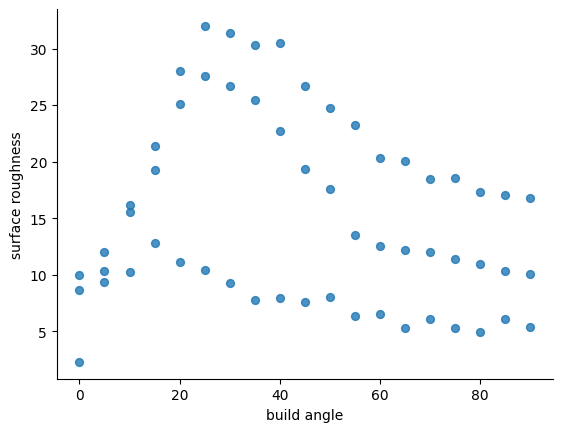

In [3]:
#Plot surface roughness vs build angle for each layer height
from matplotlib import pyplot as plt
data.plot(kind='scatter', x='build angle', y='surface roughness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
# Convert DataFrame columns to NumPy arrays explicitly
X = data[['layer height', 'build angle']].values  # Convert to NumPy array
Y = data['surface roughness'].values.reshape(-1, 1)  # Ensure Y is 2D

# Define separate scalers for X and Y
X_scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scalers on training data
X_scaled = X_scaler.fit_transform(X)
Y_scaled = Y_scaler.fit_transform(Y)


In [5]:

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)

# Train the model
gam = GammaGAM().fit(X_train, y_train)

In [6]:
from sklearn.metrics import r2_score

# Predict on test data
y_test_pred = gam.predict(X_test)

# Compute R² Score
r2 = r2_score(y_test, y_test_pred)

# Compute Adjusted R² Score
n = X_test.shape[0]  # Number of test samples
p = X_test.shape[1]  # Number of predictor variables

adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Print the scores
print("R² Score:", r2)
print("Adjusted R² Score:", adjusted_r2)


R² Score: 0.9231252414211012
Adjusted R² Score: 0.9060419617369014


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Inverse transform X_test to get original values
X_test_original = X_scaler.inverse_transform(X_test)

# Extract original 'ang' values
ang_original = X_test_original[:, 1]

# Inverse transform y_test and y_pred to original scale
y_test_original = Y_scaler.inverse_transform(y_test)
y_pred_original = Y_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

# Create a DataFrame for visualization
results = pd.DataFrame({
    'Ang': ang_original,
    'Actual': y_test_original.flatten(),  # Flatten to 1D array
    'Predicted': y_pred_original.flatten()
})

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(results['Ang'], results['Actual'], color='green', label='Actual', alpha=0.7)
plt.scatter(results['Ang'], results['Predicted'], color='black', label='Predicted', alpha=0.7)
plt.xlabel('Build angle')
plt.ylabel('Surface roughness')
plt.title('Actual vs. Predicted Surface roughness')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'y_pred' is not defined

In [8]:
# Get new user inputs
new_layer_height = float(input("Enter the new value for layer height in micron: "))
new_build_angle = float(input("Enter the new value for build angle in degree: "))

# Convert new input values into a NumPy array
X_new = np.array([[new_layer_height, new_build_angle]])

# Standardize new input
X_new_scaled = X_scaler.transform(X_new)

# Predict scaled output
ra_new_pred_scaled = gam.predict(X_new_scaled)

# Inverse transform prediction
ra_new_pred_original = Y_scaler.inverse_transform(ra_new_pred_scaled.reshape(-1, 1))

print("Predicted Surface roughness in micron:", ra_new_pred_original[0][0])

ValueError: could not convert string to float: ''

In [ ]:
import pickle

# Save the trained model and scalers
with open("gam_model.pkl", "wb") as model_file:
    pickle.dump({
        "model": gam,  # The trained GammaGAM model
        "X_scaler": X_scaler,  # Scaler for input features
        "Y_scaler": Y_scaler   # Scaler for output
    }, model_file)

print("Model saved successfully!")


Model saved successfully!


In [ ]:
import streamlit as st
import pickle
import numpy as np

# Load the saved model and scalers
with open("gam_model.pkl", "rb") as model_file:
    saved_objects = pickle.load(model_file)

gam = saved_objects["model"]  # Load trained model
X_scaler = saved_objects["X_scaler"]  # Load X scaler
Y_scaler = saved_objects["Y_scaler"]  # Load Y scaler

# Streamlit UI
st.title("Machine SOP Chatbot - Predict Rq")

# Get user input
new_lh = st.number_input("Enter the new value for lh:", min_value=0.0, step=0.01)
new_ang = st.number_input("Enter the new value for ang:", min_value=0.0, step=0.01)

if st.button("Predict"):
    # Standardize the new input
    X_new = np.array([[new_lh, new_ang]])
    X_new_scaled = X_scaler.transform(X_new)

    # Predict Rq
    ra_new_pred_scaled = gam.predict(X_new_scaled)

    # Convert prediction back to original scale
    ra_new_pred_original = Y_scaler.inverse_transform(ra_new_pred_scaled.reshape(-1, 1))

    # Display the result
    st.success(f"Predicted Rq: {ra_new_pred_original[0][0]:.4f}")